In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob


In [2]:
def load_and_process_data(file_path):
    processed_data = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                data = json.loads(line)
                group_id = data['group']
                current_probe_counts_vector = data['probe_counts']

                if group_id not in processed_data:
                    processed_data[group_id] = {
                        'probe_counts_vectors': [],
                        'vector_length': 0
                    }

                if len(processed_data[group_id]['probe_counts_vectors']) < 30:
                    processed_data[group_id]['probe_counts_vectors'].append(current_probe_counts_vector)

                if processed_data[group_id]['vector_length'] == 0 and current_probe_counts_vector:
                    processed_data[group_id]['vector_length'] = len(current_probe_counts_vector)

        print("Successfully loaded and processed group_traces.jsonl")
        print("\nGroups loaded:", list(processed_data.keys()))

        if processed_data:
            first_group_key = list(processed_data.keys())[0]
            # print(f"\nExample entry for '{first_group_key}':\n", processed_data[first_group_key])
        else:
            print("No data was processed.")
        return processed_data

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
def calculate_minimized_vectors(processed_data):
    minimized_vectors_per_group = {}

    if processed_data is None: # Handle case where data loading failed
        print("Cannot calculate minimized vectors: processed_data is None.")
        return None

    for group_id, group_data in processed_data.items():
        probe_vectors = group_data['probe_counts_vectors']

        if probe_vectors:
            np_probe_vectors = np.array(probe_vectors)
            minimized_vector = np.min(np_probe_vectors, axis=0)
            minimized_vectors_per_group[group_id] = minimized_vector.tolist()

    print("Successfully calculated minimized probe count vectors for the following groups:", list(minimized_vectors_per_group.keys()))

    if minimized_vectors_per_group:
        first_minimized_group_key = list(minimized_vectors_per_group.keys())[0]
        # print(f"\nExample minimized vector for group '{first_minimized_group_key}':\n", minimized_vectors_per_group[first_minimized_group_key])
    else:
        print("No minimized vectors were computed.")
    return minimized_vectors_per_group

In [9]:
import numpy as np

def hierarchical_group_sort(vectors_dict, threshold=0):
    # Convert dict to sorted list of groups
    group_keys = sorted(vectors_dict.keys())
    M = np.array([vectors_dict[k] for k in group_keys], dtype=float)

    num_groups, width = M.shape
    col_order = np.arange(width)

    next_start = 0

    for g in range(num_groups):
        # 1) Sort the slice M[g, next_start:] in descending order
        slice_vec = M[g, next_start:]
        local_indices = np.argsort(slice_vec)[::-1]  # descending

        # Build full permutation for this stage
        perm = np.concatenate([
            np.arange(next_start),               # untouched prefix
            next_start + local_indices           # reordered suffix
        ])

        # Apply permutation globally
        M = M[:, perm]
        col_order = col_order[perm]

        # 2) Update next_start:
        # Find last index where the value == threshold in current group
        new_region = M[g, next_start:]
        threshold_positions = np.where(new_region == threshold)[0]

        if len(threshold_positions) > 0:
            last_pos = threshold_positions[-1] + next_start
            next_start = last_pos + 1
        else:
            # If threshold does not appear — no more sorting possible
            break

        # If next_start reaches the end → done
        if next_start >= width:
            break

    # Build result dict again
    out = {}
    for i, k in enumerate(group_keys):
        out[k] = M[i].tolist()

    return out, col_order.tolist()


In [5]:
def generate_all_heatmaps(groups_vector, filename_prefix="heatmap"):

    if groups_vector is None or not groups_vector:
        print("No averaged vectors available for heatmap generation.")
        return

    heatmaps_dir = "heatmaps"
    os.makedirs(heatmaps_dir, exist_ok=True)

    # Stack all averaged vectors into a single 2D NumPy array
    # Each row will be a group's averaged vector, and columns will be probe indices
    all_averaged_data = np.array(list(groups_vector.values()))

    print(f"Shape of the combined data for heatmap: {all_averaged_data.shape}")

    # Create the heatmap
    plt.figure(figsize=(20, 10)) # Adjust figure size for better readability given the large number of columns
    sns.heatmap(all_averaged_data, cmap='viridis', cbar=True, yticklabels=list(groups_vector.keys()))

    plt.title('Heatmap of Averaged Probe Counts Across All Groups and Probe Indices')
    plt.xlabel('Probe Index (12288 cells)')
    plt.ylabel('Group ID (64 groups)')
    plt.tight_layout() # Adjust layout to prevent labels from being cut off
        # Save the heatmap to file
    output_path = os.path.join(heatmaps_dir, f"{filename_prefix}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Heatmap saved to: {output_path}")
    
    plt.show()

    print("Heatmap generation complete.")

# Task
Summarize the heatmaps generated for the `0_group_tracesT.jsonl` and `1_group_tracesT.jsonl` files.

## List all JSONL files

### Subtask:
Identify all files ending with `.jsonl` in the `/content/` directory.


**Reasoning**:
To identify all files ending with `.jsonl` in the `/content/` directory, I will import the `glob` module and use `glob.glob()` to list them, storing the result in the `jsonl_files` variable.



In [6]:

jsonl_files = glob.glob('../*.jsonl')

print("Found JSONL files:", jsonl_files)

Found JSONL files: ['../16_group_prime.jsonl', '../4_group_prime.jsonl', '../32_group_prime.jsonl', '../1_group_no_prime1.jsonl', '../2_group_prime.jsonl', '../8_group_prime.jsonl', '../64_group_prime.jsonl', '../1_group_no_prime0.jsonl', '../1_group_prime.jsonl']


## Process and Plot Heatmaps for Each File

### Subtask:
Iterate through each `.jsonl` file found. For each file, load and process the data, calculate the averaged vectors, and then generate and display a heatmap using the `generate_all_heatmaps` function. This will produce a separate heatmap for each data file.


**Reasoning**:
I will iterate through each `.jsonl` file, process its data, calculate averaged vectors, and then generate a heatmap for each file using the functions defined earlier, as instructed.




Processing file: ../16_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Shape of the combined data for heatmap: (16, 16384)
Heatmap saved to: heatmaps/16_group_prime.png


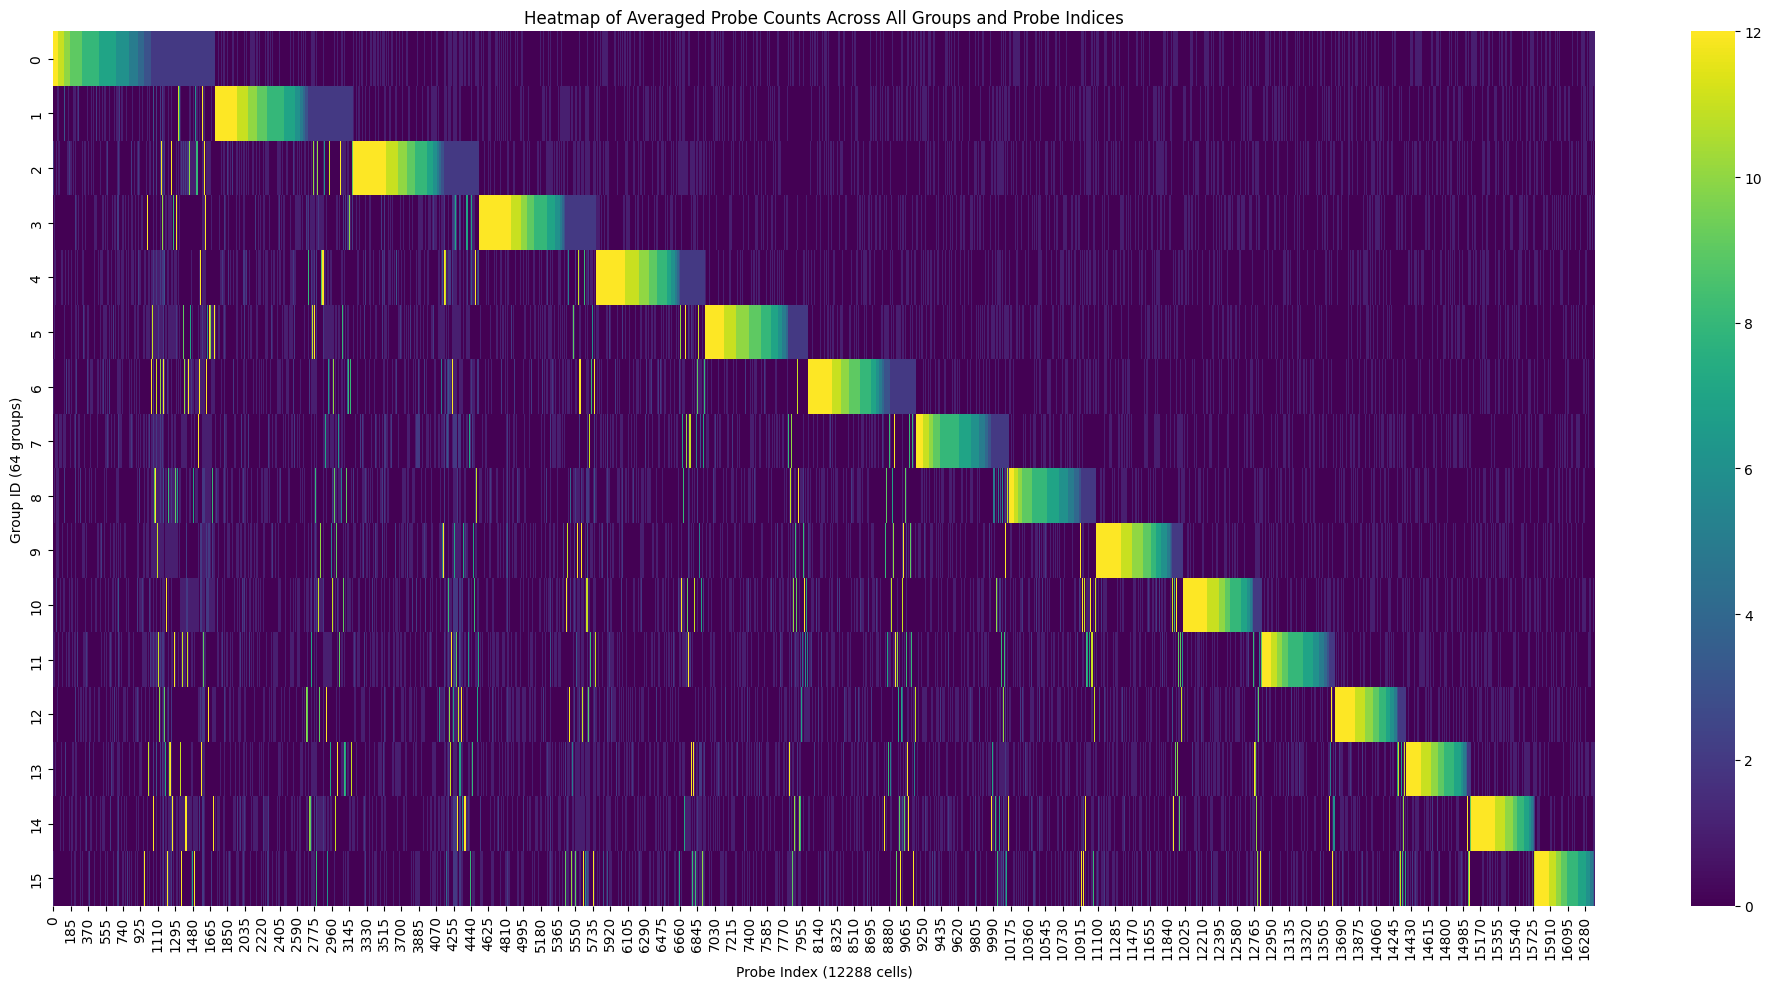

Heatmap generation complete.

Processing file: ../4_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3]
Shape of the combined data for heatmap: (4, 16384)
Heatmap saved to: heatmaps/4_group_prime.png


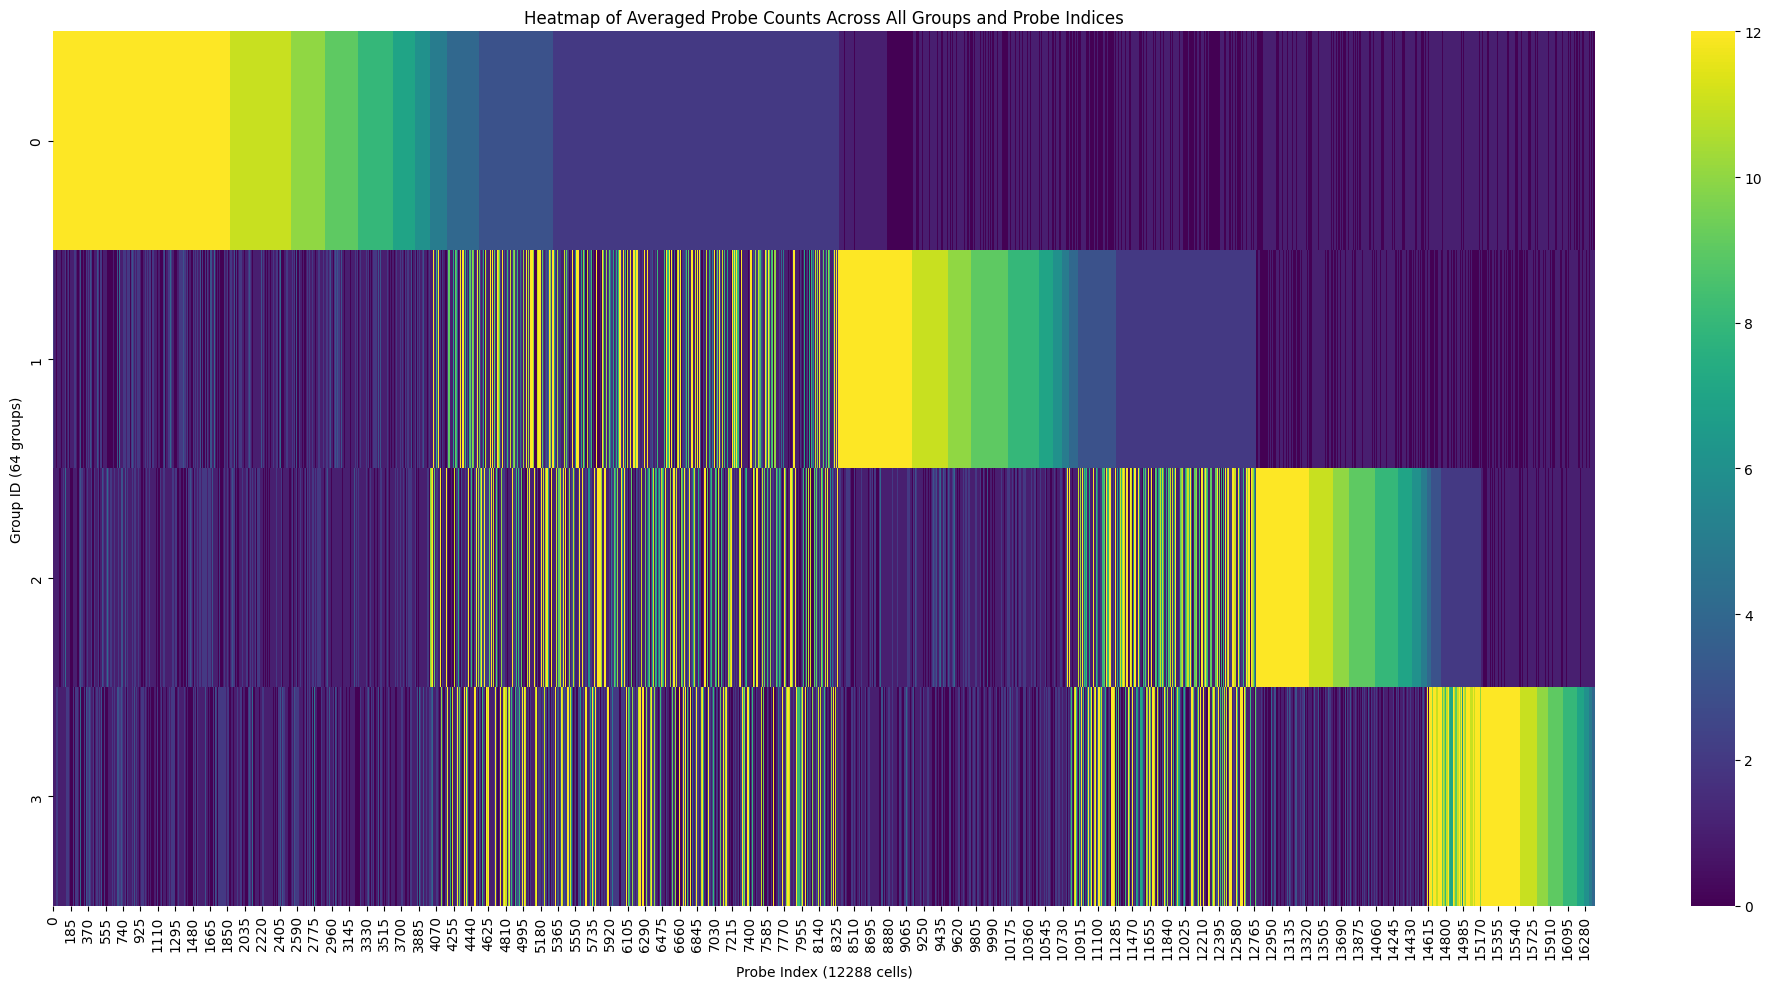

Heatmap generation complete.

Processing file: ../32_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Shape of the combined data for heatmap: (32, 16384)
Heatmap saved to: heatmaps/32_group_prime.png


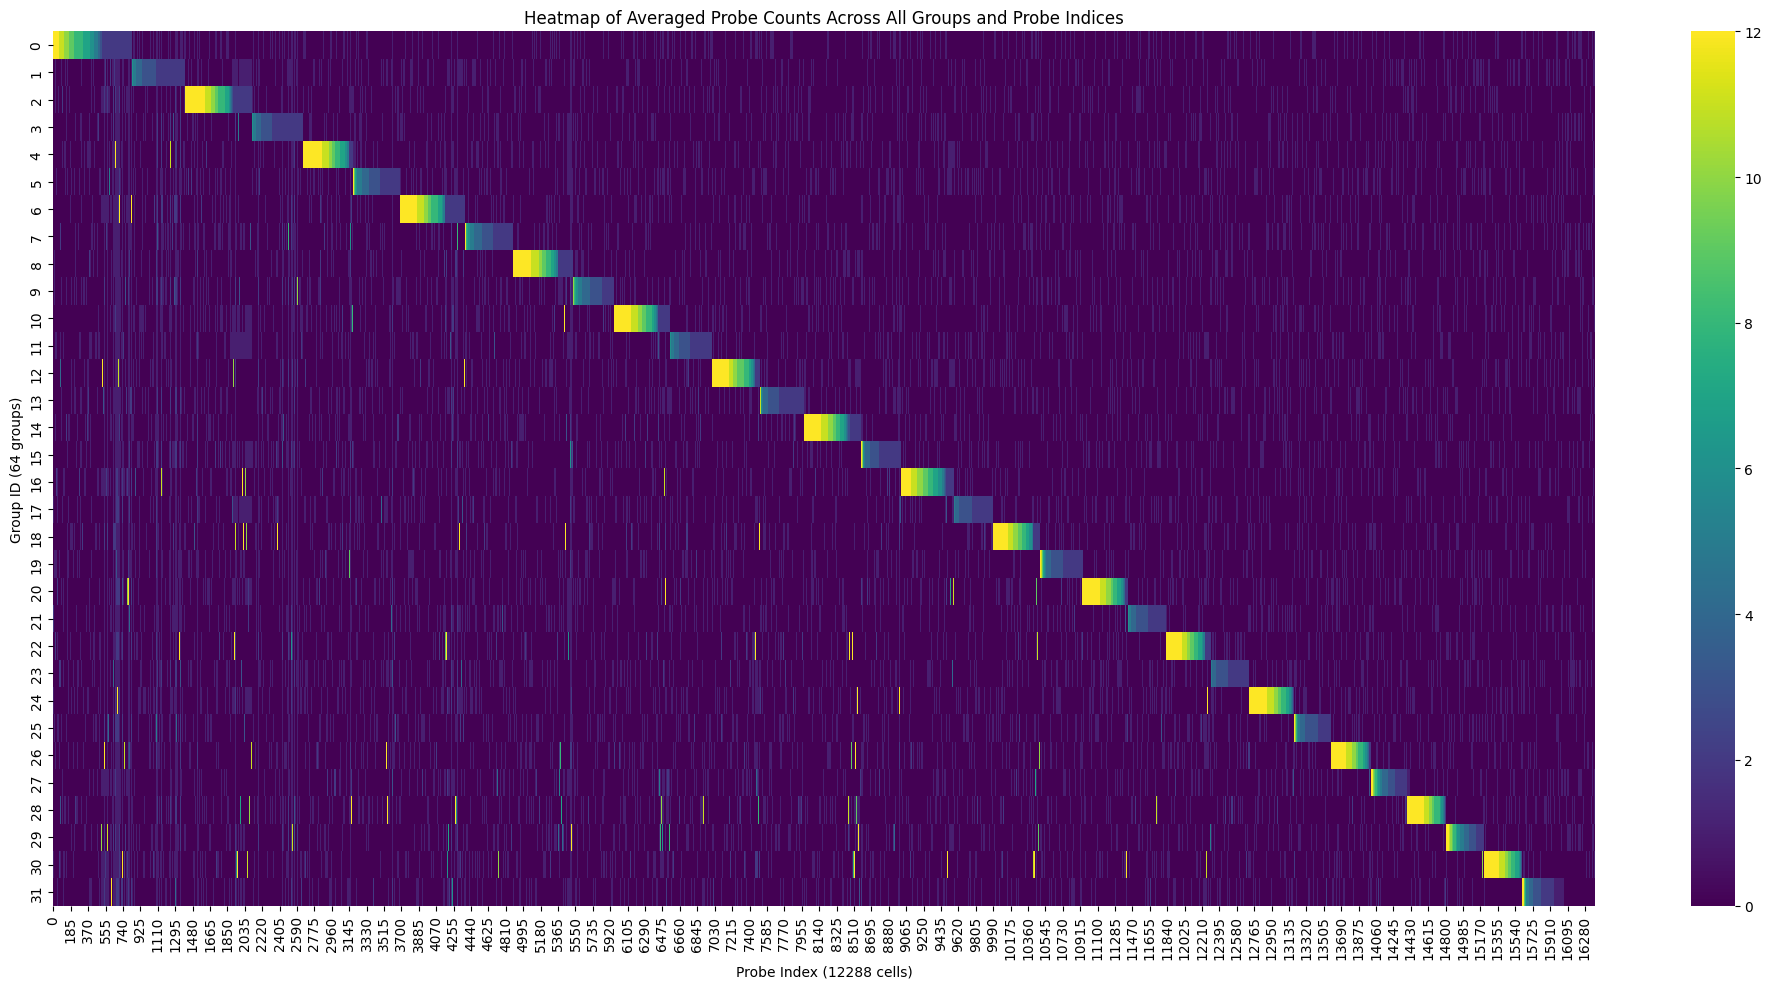

Heatmap generation complete.

Processing file: ../1_group_no_prime1.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0]
Successfully calculated minimized probe count vectors for the following groups: [0]
Shape of the combined data for heatmap: (1, 16384)
Heatmap saved to: heatmaps/1_group_no_prime1.png


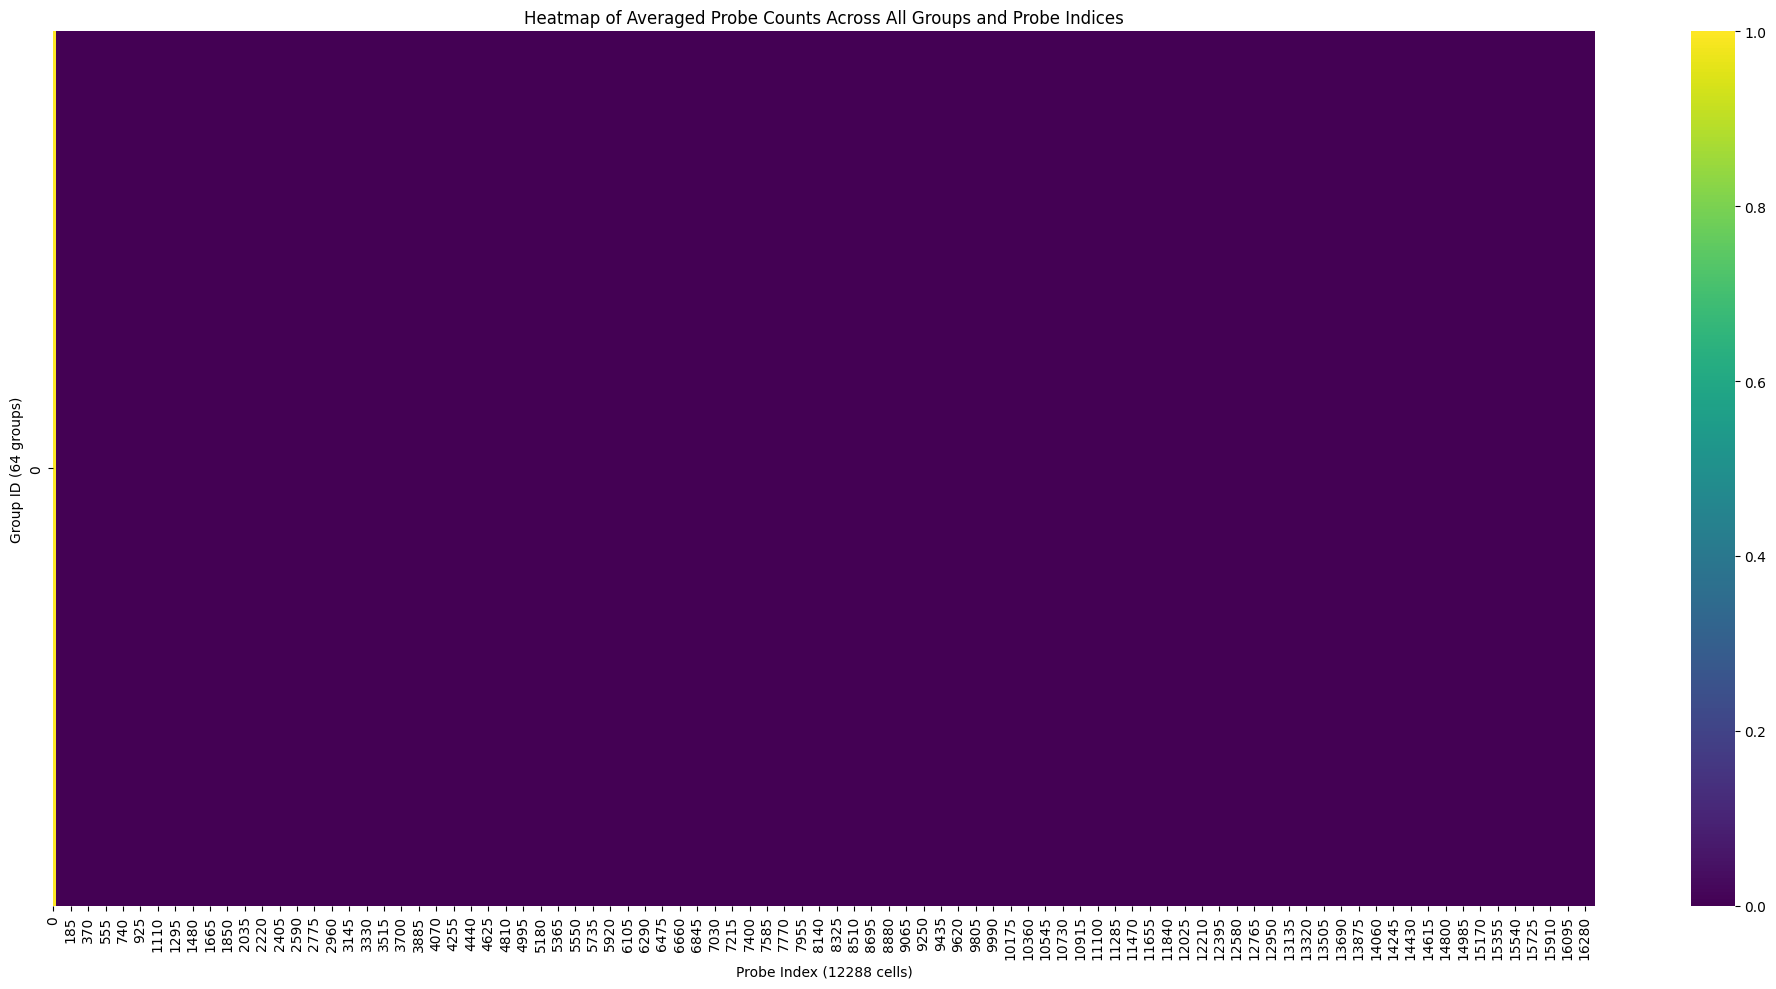

Heatmap generation complete.

Processing file: ../2_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1]
Successfully calculated minimized probe count vectors for the following groups: [0, 1]
Shape of the combined data for heatmap: (2, 16384)
Heatmap saved to: heatmaps/2_group_prime.png


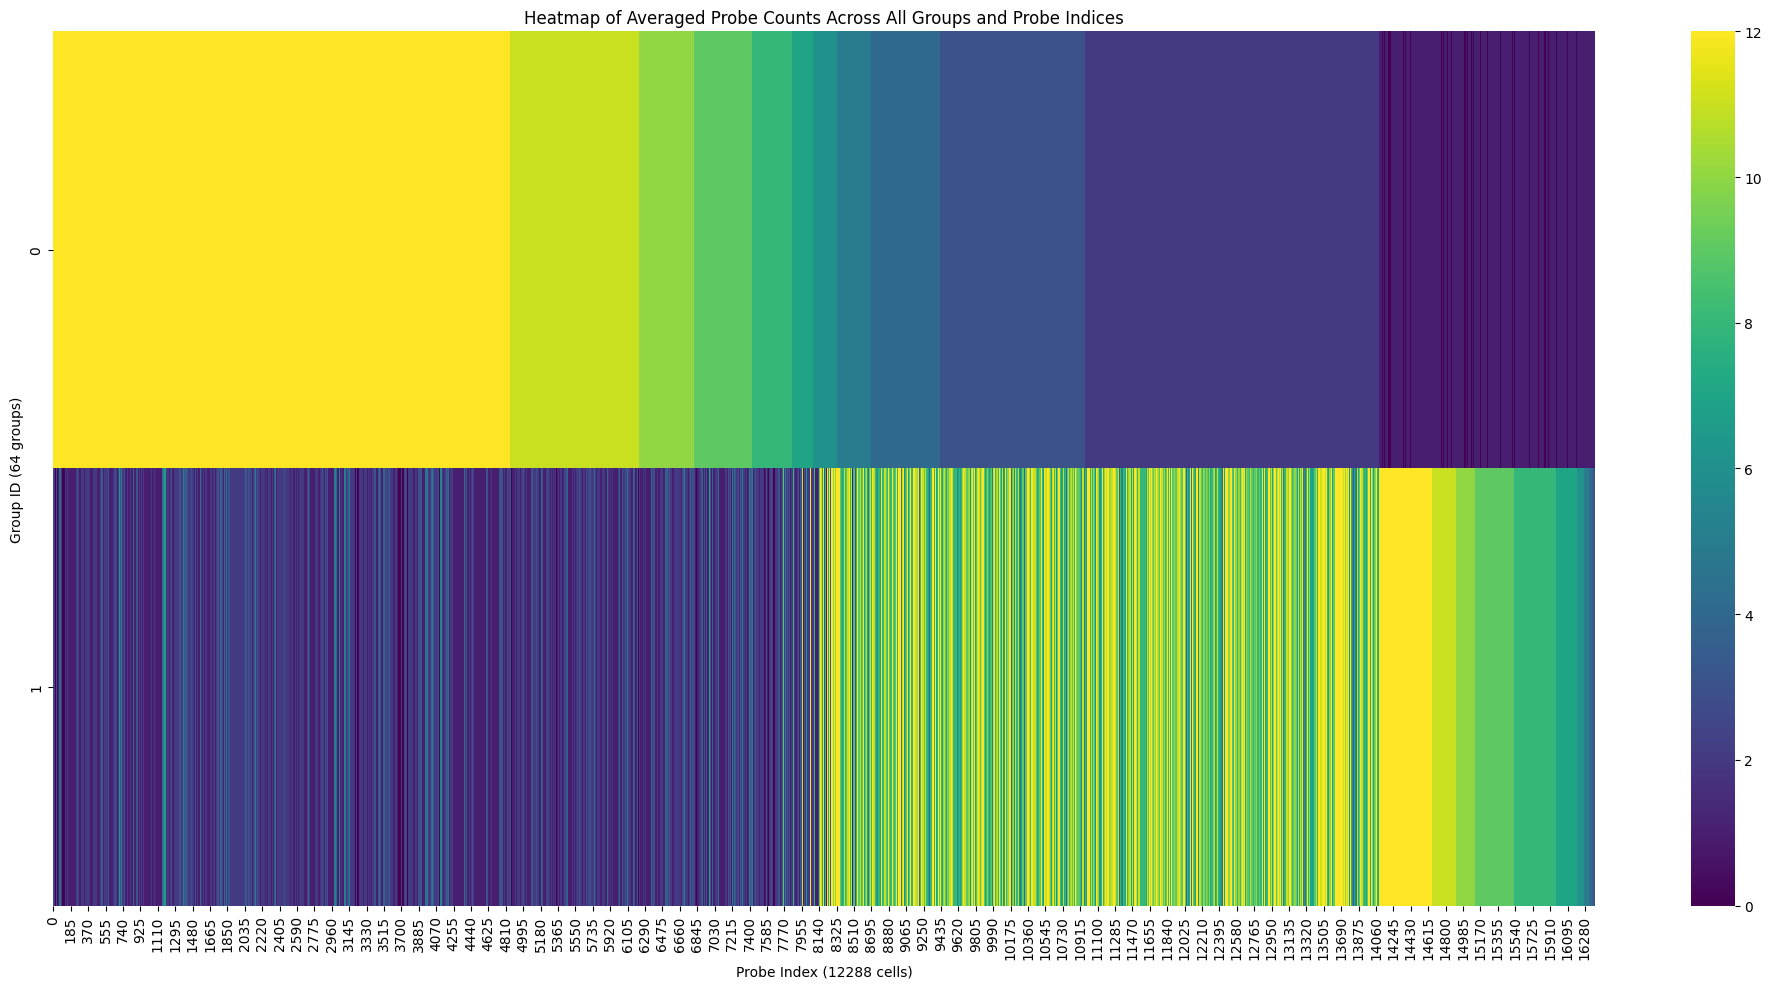

Heatmap generation complete.

Processing file: ../8_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7]
Shape of the combined data for heatmap: (8, 16384)
Heatmap saved to: heatmaps/8_group_prime.png


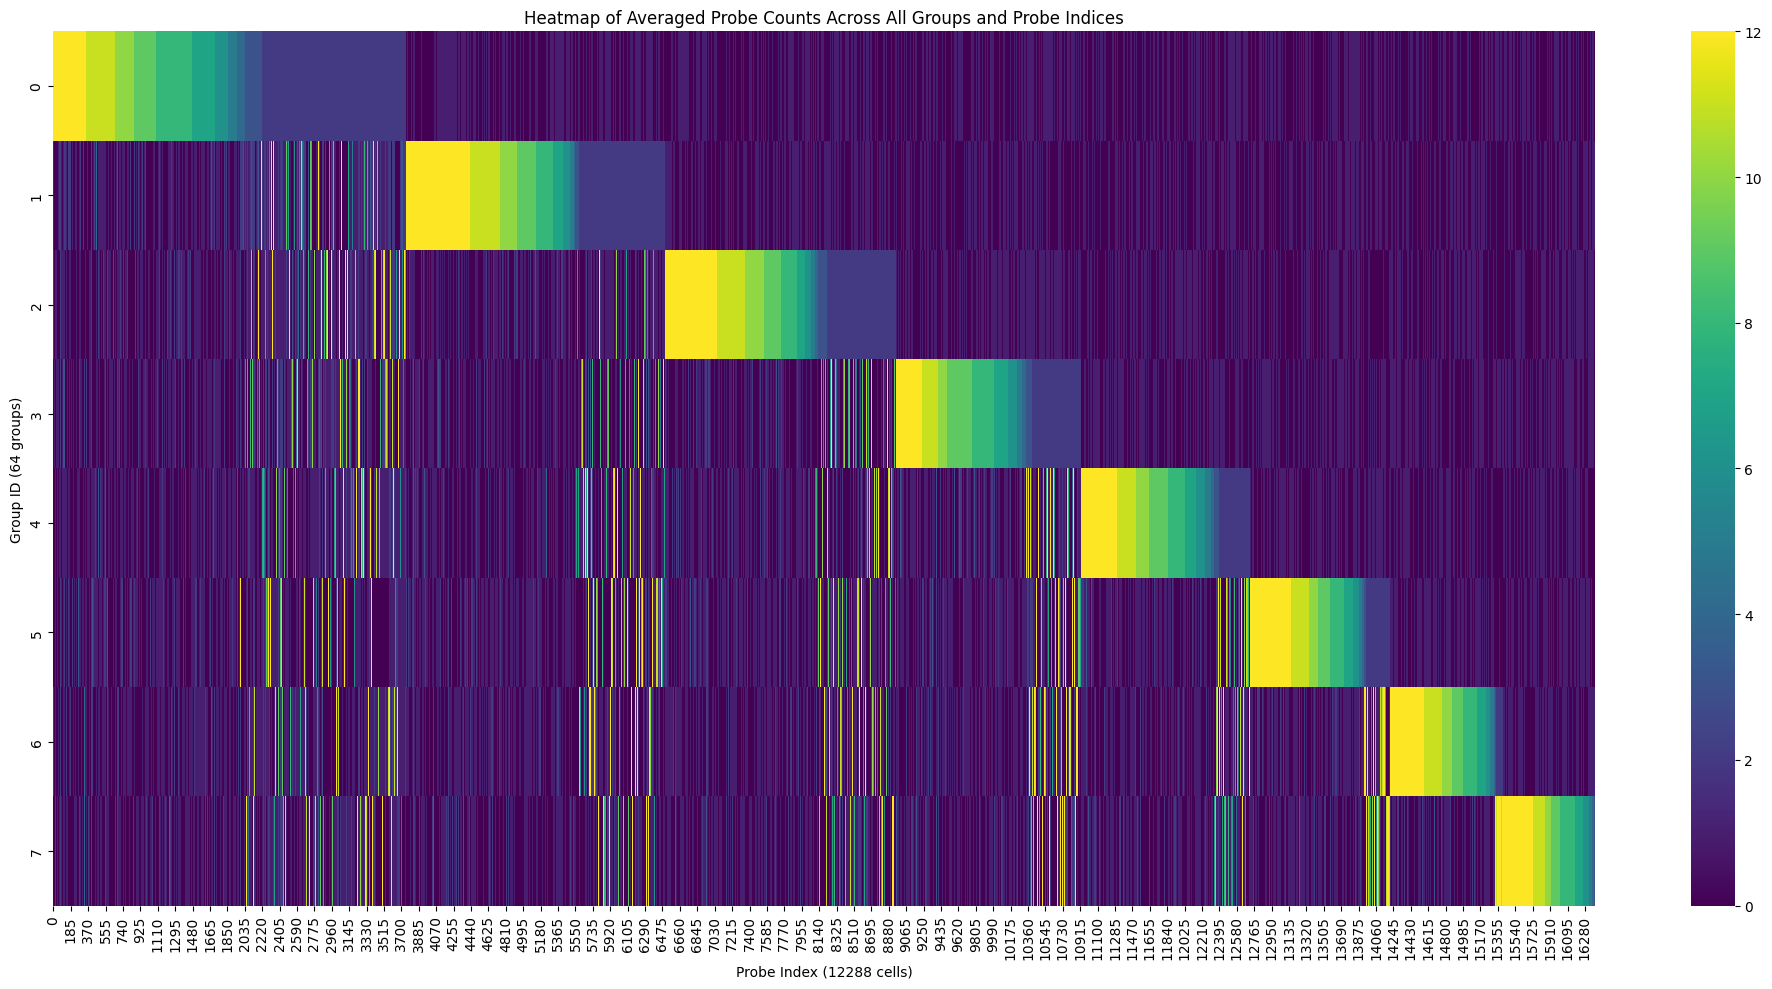

Heatmap generation complete.

Processing file: ../64_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
Shape of the combined data for heatmap: (64, 16384)
Heatmap saved to: heatmaps/64_group_prime.png


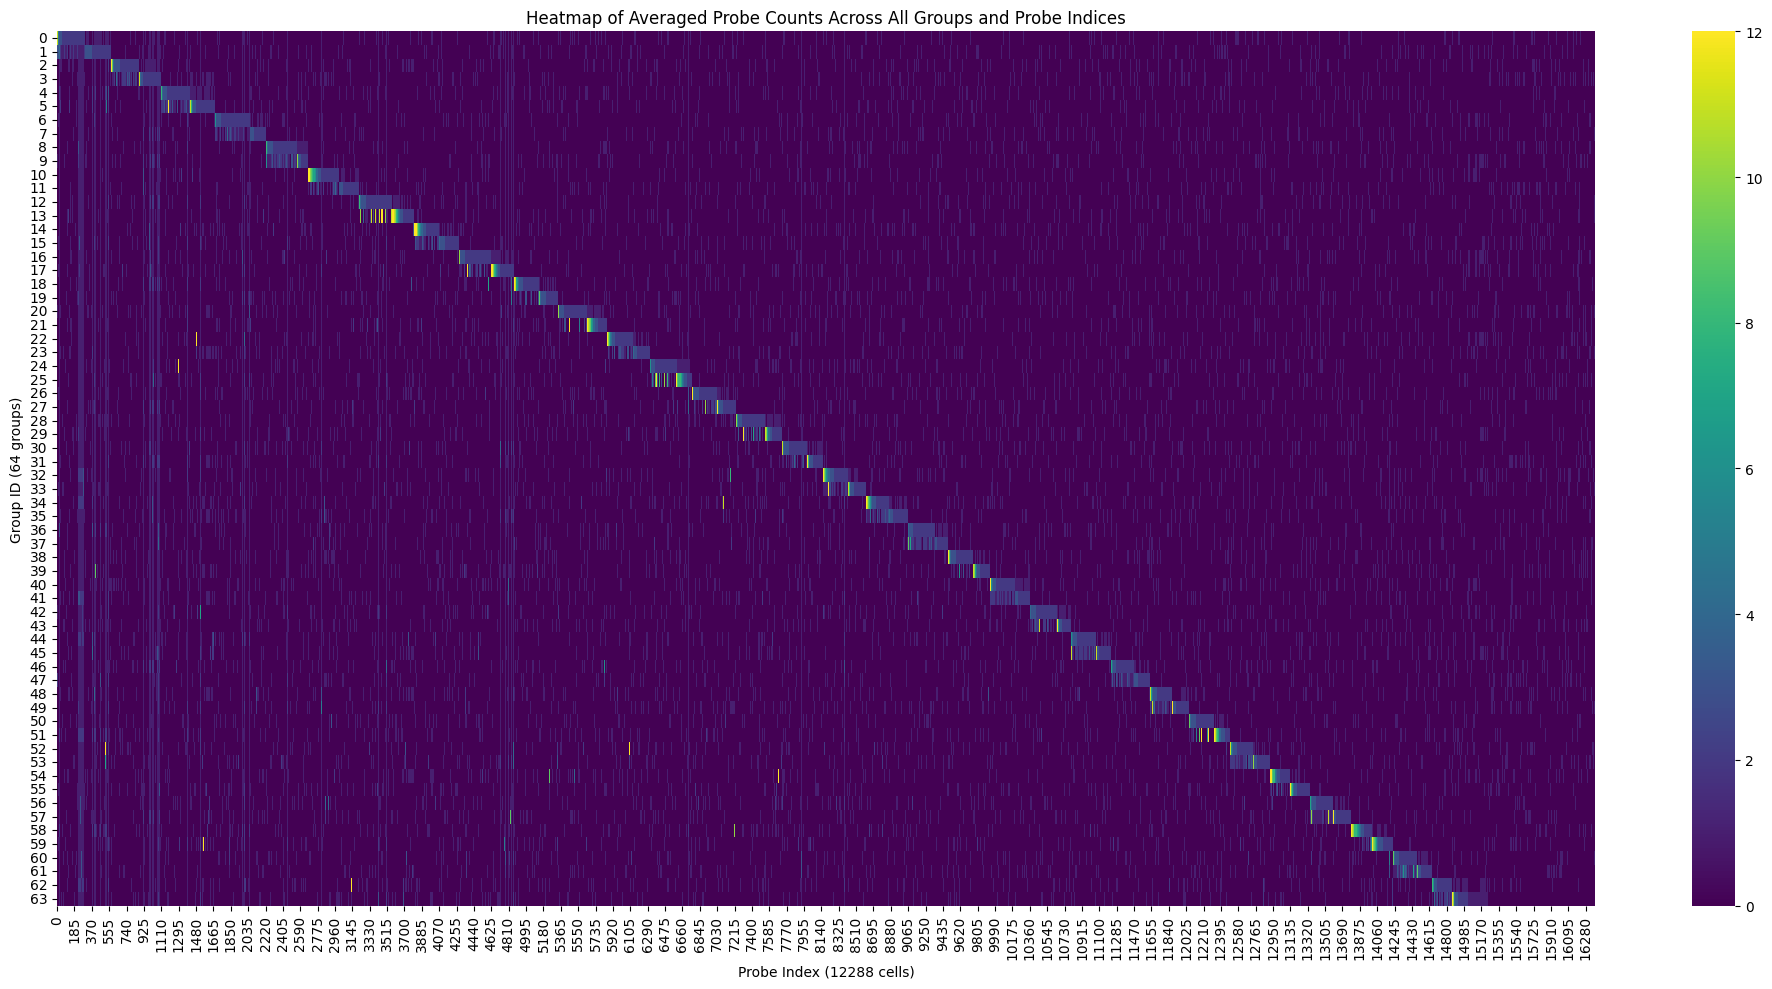

Heatmap generation complete.

Processing file: ../1_group_no_prime0.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0]
Successfully calculated minimized probe count vectors for the following groups: [0]
Shape of the combined data for heatmap: (1, 16384)
Heatmap saved to: heatmaps/1_group_no_prime0.png


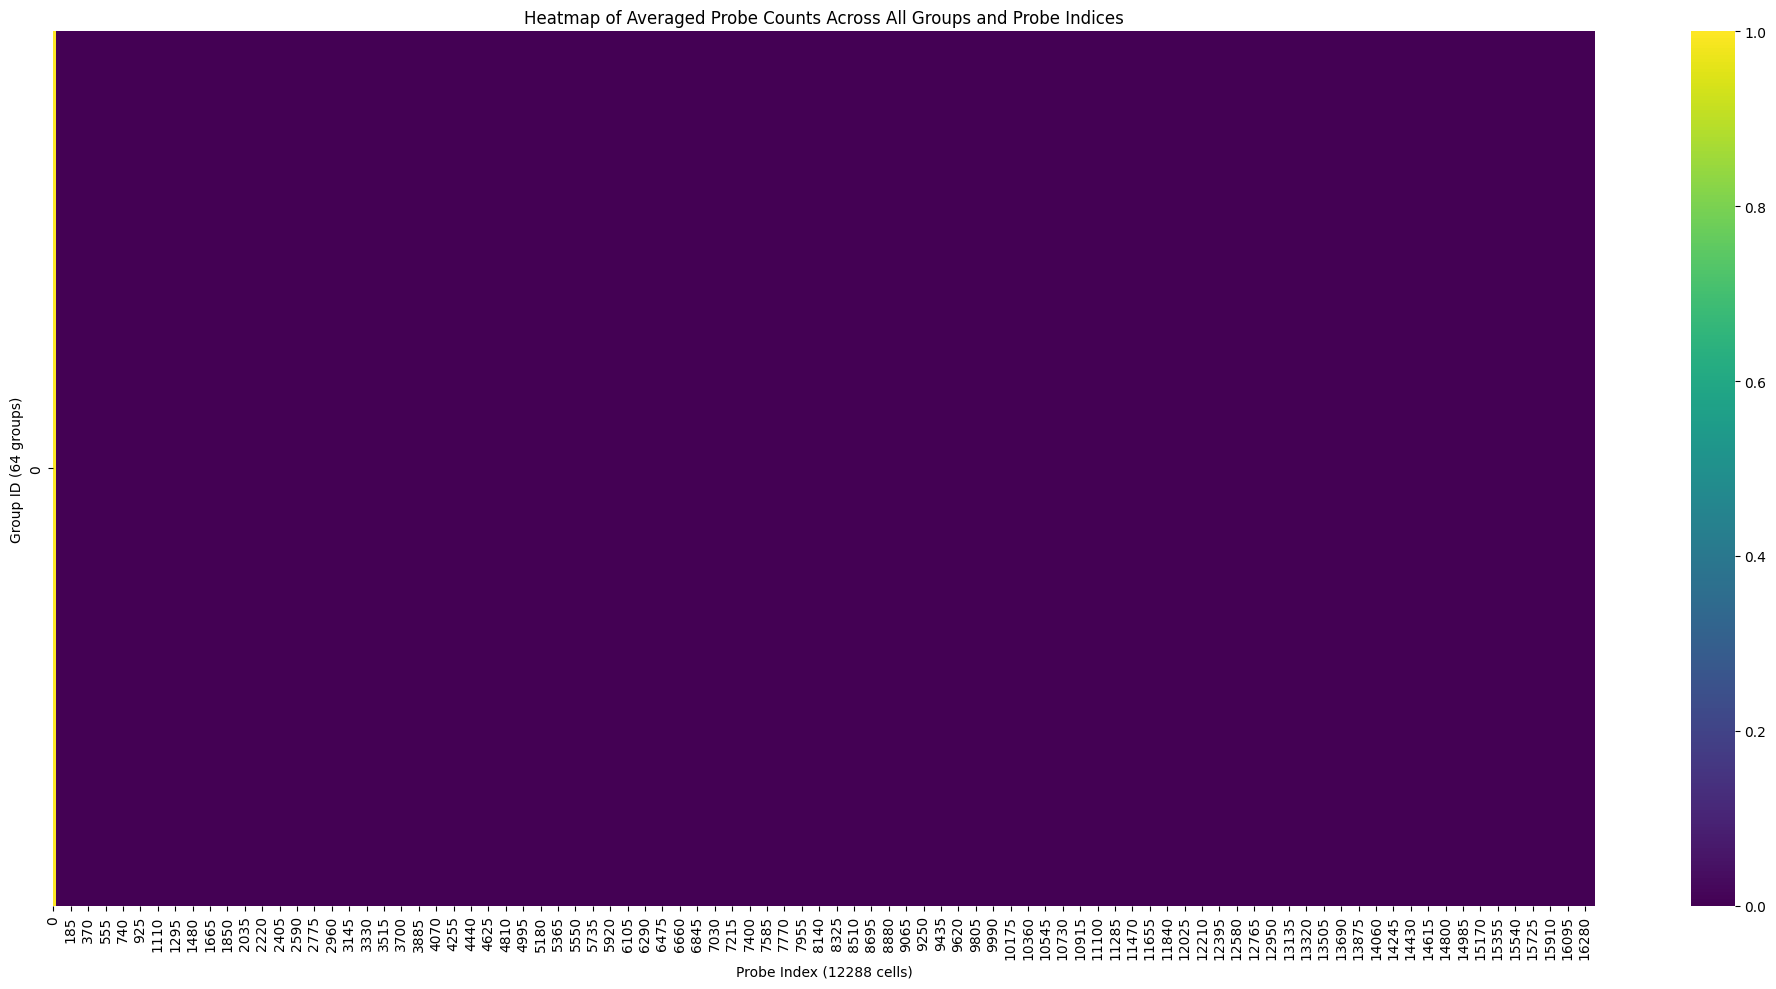

Heatmap generation complete.

Processing file: ../1_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0]
Successfully calculated minimized probe count vectors for the following groups: [0]
Shape of the combined data for heatmap: (1, 16384)
Heatmap saved to: heatmaps/1_group_prime.png


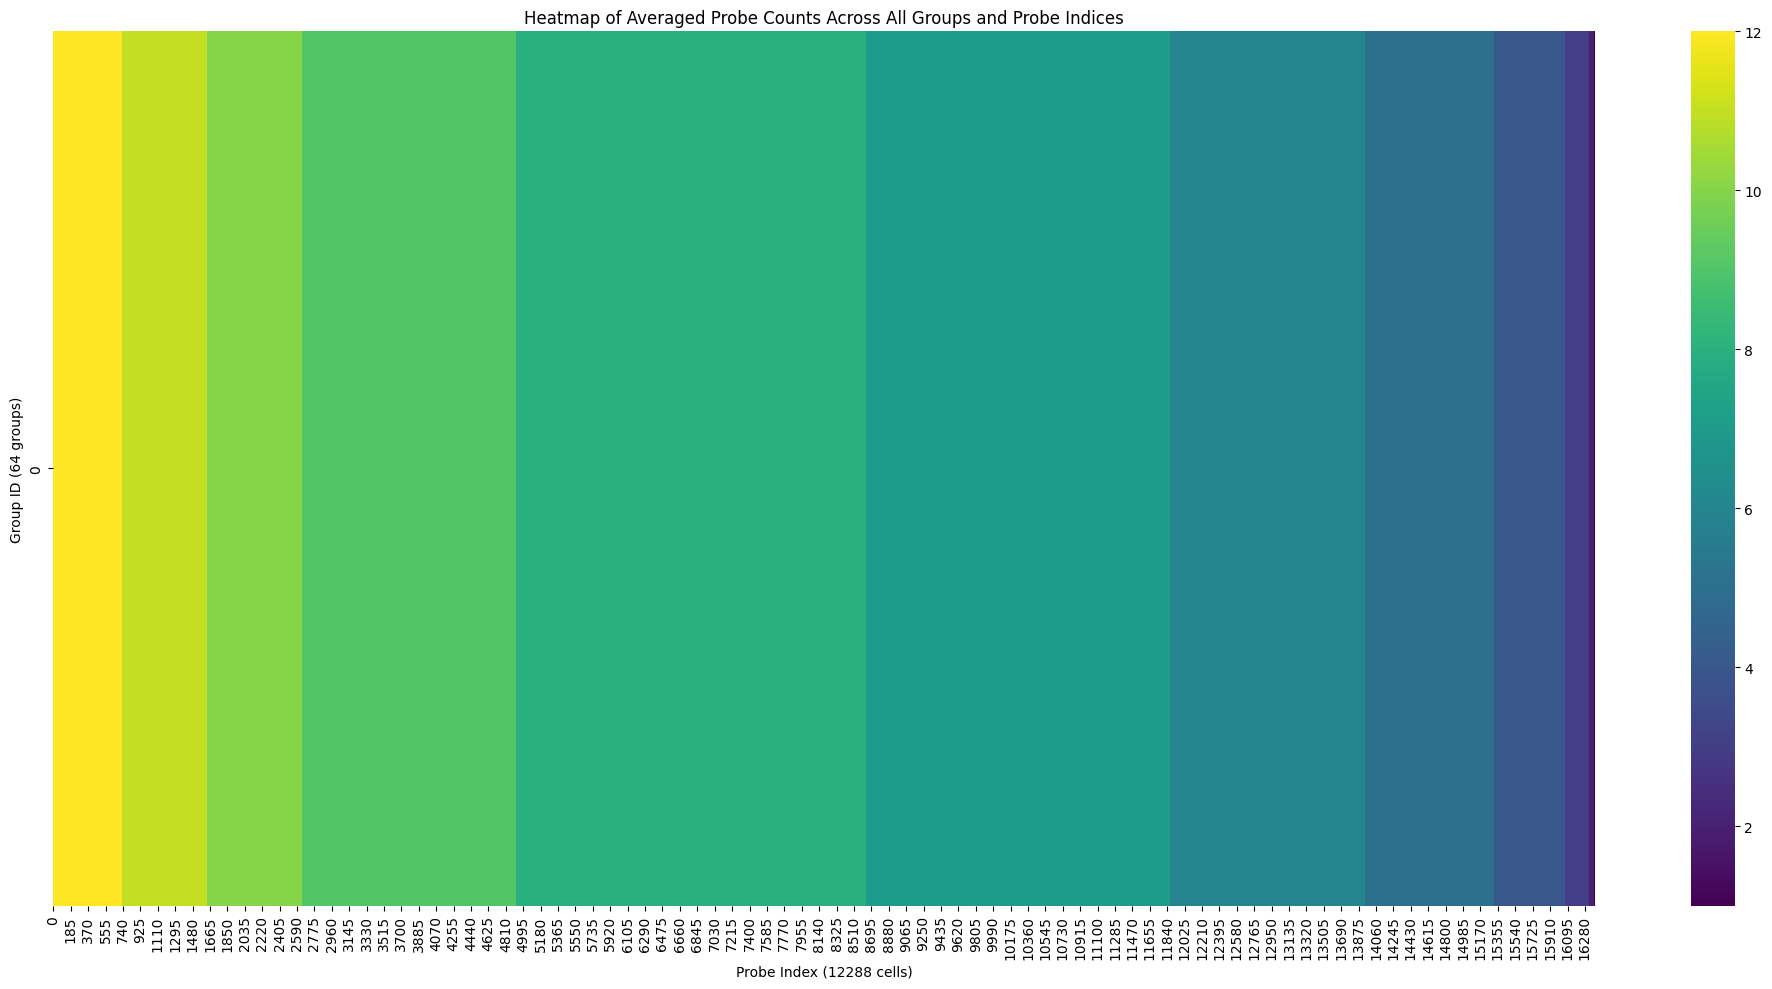

Heatmap generation complete.


In [17]:
for file_path in jsonl_files:
    print(f"\nProcessing file: {file_path}")
    processed_data = load_and_process_data(file_path)
    if processed_data:
        minimized_vectors_per_group = calculate_minimized_vectors(processed_data)
        reordered_vectors, col_order = hierarchical_group_sort(minimized_vectors_per_group, threshold=2)
        if minimized_vectors_per_group:
            filename_base = os.path.splitext(os.path.basename(file_path))[0]
            # generate_all_heatmaps(minimized_vectors_per_group, filename_prefix=filename_base)
            generate_all_heatmaps(reordered_vectors, filename_prefix=filename_base)


        else:
            print(f"Could not calculate minimized vectors for {file_path}.")
    else:
        print(f"Could not load and process data from {file_path}.")